# Exploration

We will be building a statistical model to estimate the distribution of Pokemon stats and to predict the stats of future (or unseen) Pokemons.

Let us first inspect the data:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
pokemon = pd.read_csv("./Pokemon.csv")

In [4]:
pokemon.shape

(800, 13)

In [5]:
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [6]:
pokemon.describe()

,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,362.813750,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,208.343798,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,1.000000,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,184.750000,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,364.500000,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,539.250000,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,721.000000,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


In [7]:
pokemon.describe(exclude=[np.number])

,Name,Type 1,Type 2,Legendary
count,800,800,414,800
unique,800,18,18,2
top,BlastoiseMega Blastoise,Water,Flying,False
freq,1,112,97,735


Some characteristics of the data:

1. There are 13 attributes (including ID) per pokemon, and there are 800 pokemons in total.
2. All the 6 basic stats are on the same order of magnitude in terms of range, and have similar std as well. HP has the lowest deviation whereas Sp.Atk has the highest. The range of total stat points is pretty large.
3. All pokemons have one type, and about half of them have two types.

Let us compare the pokemon stat values pairwise:

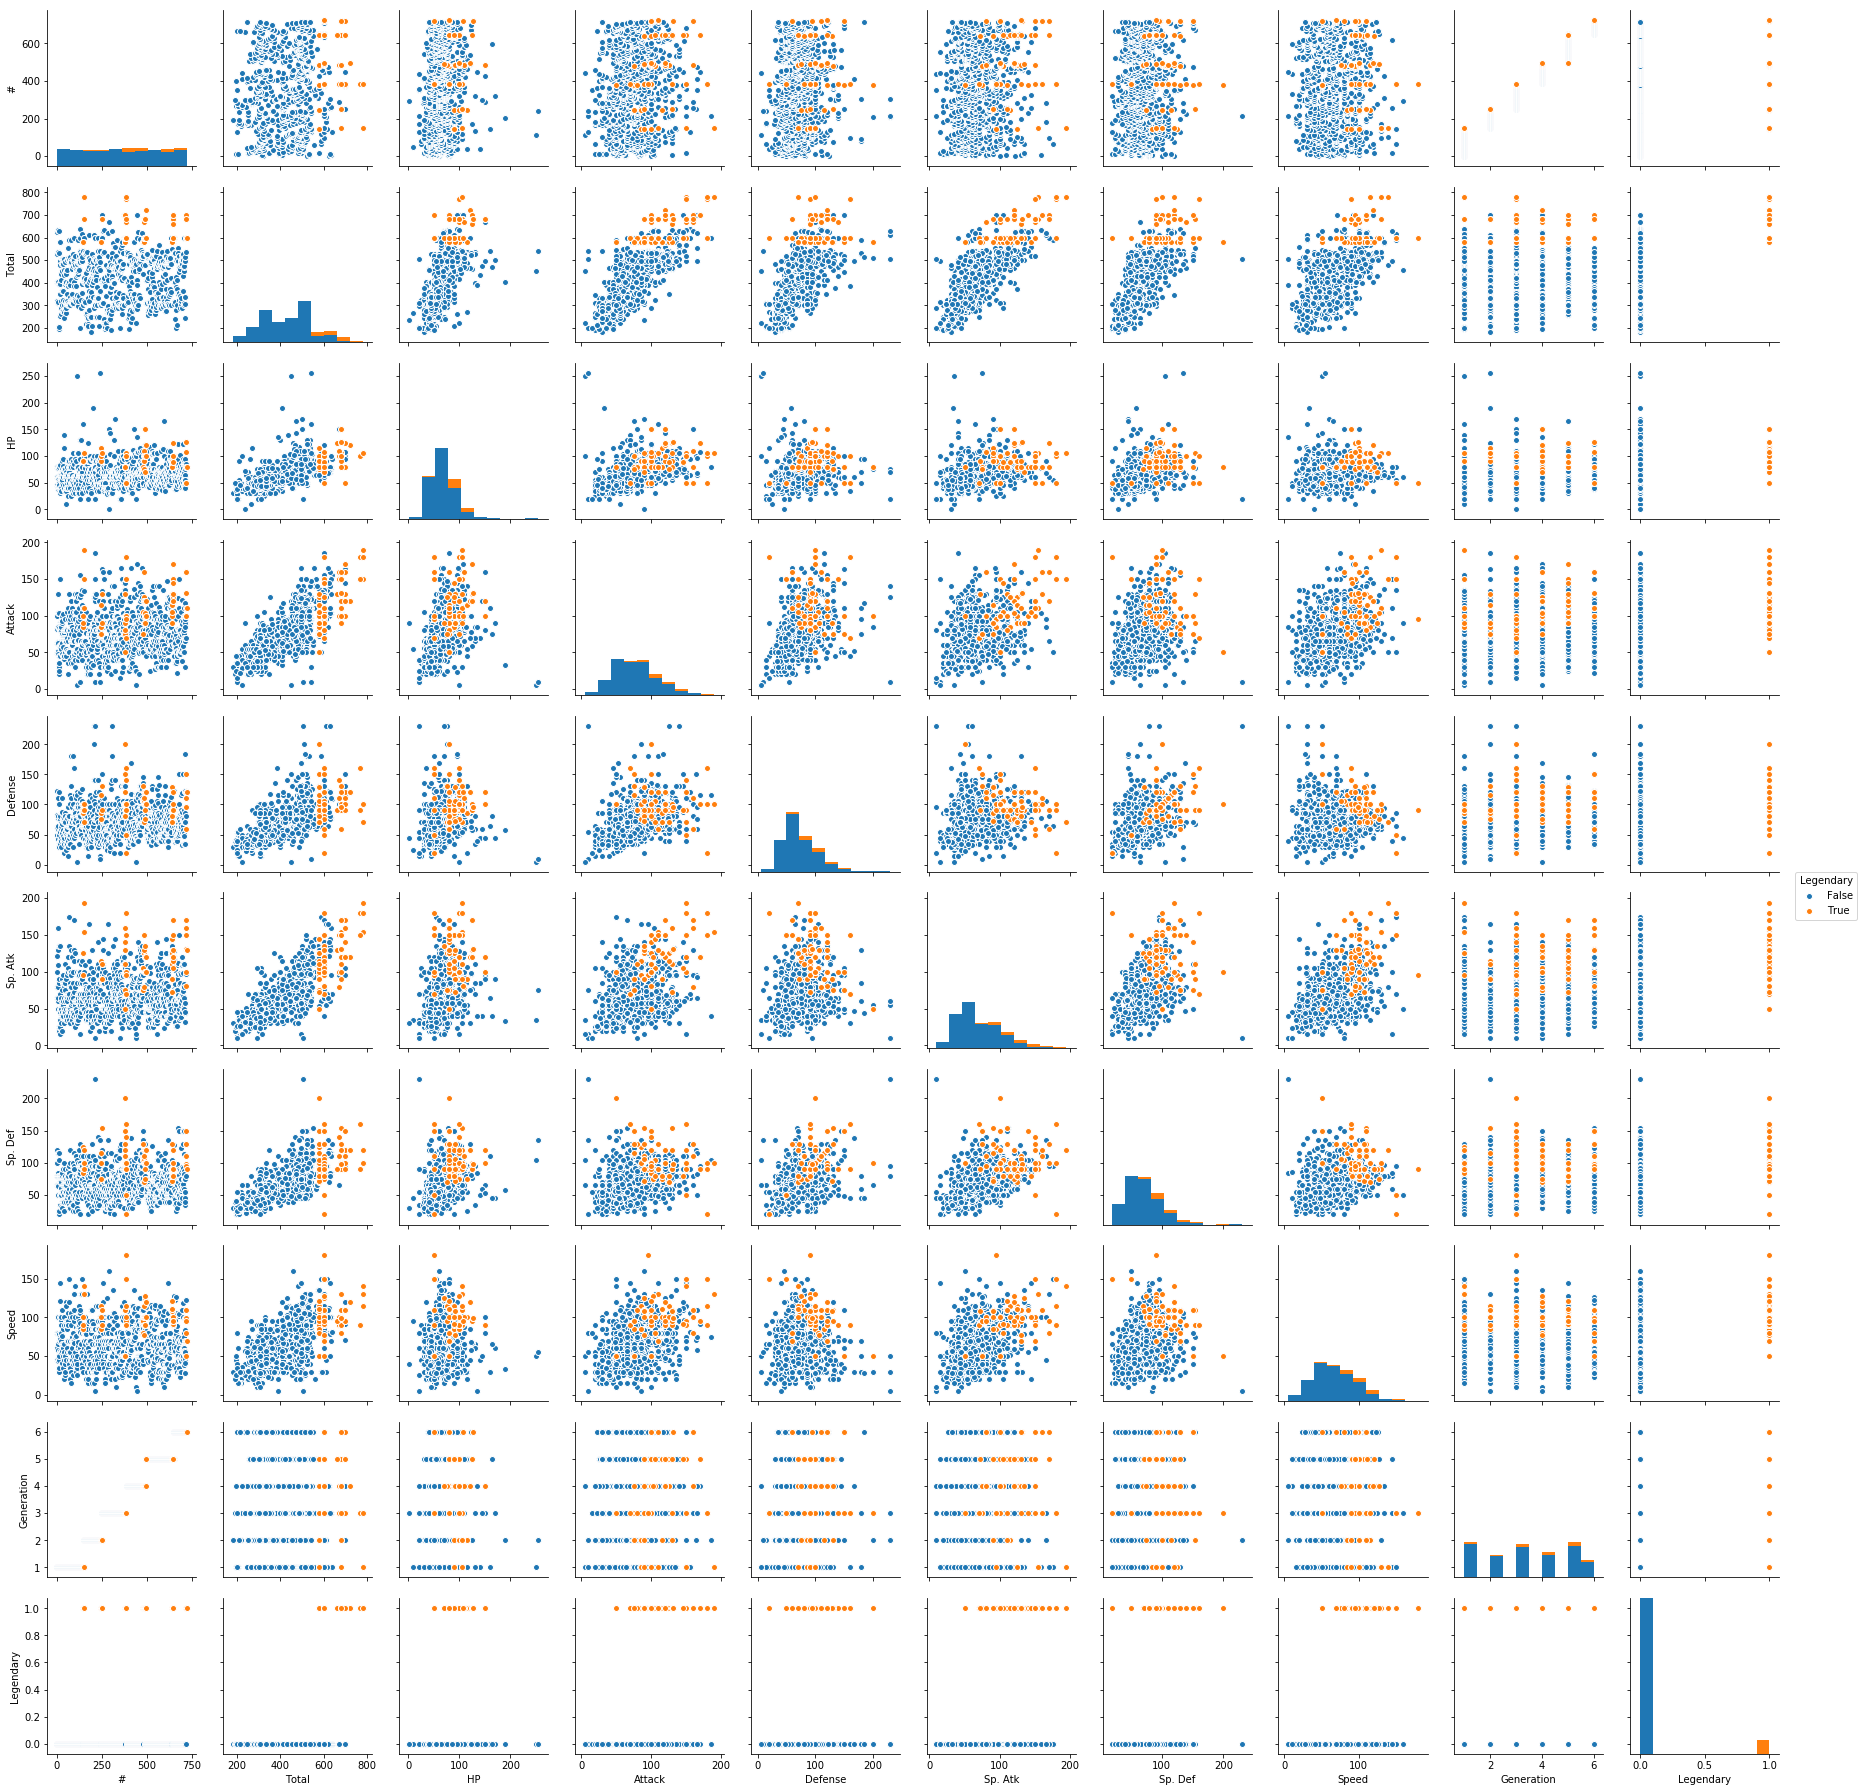

In [8]:
sns.pairplot(pokemon, hue='Legendary')

We found some further insights:

1. Stats are distributed rather evenly across generations barring a few outliers, but the averages seem to increase by pokemon IDs - likely power creep?
2. Individual stats are somewhat positively correlated with total stats.
3. All stats are skewed to the right.
4. The correlations between individual stats are not clear.
5. Legendaries have significantly higher total stats.

We would also like to know the relationship between type and stats.

In [9]:
vec_concat = np.vectorize(lambda x, y: " ".join([x, y]))

In [10]:
pokemon['CombinedType'] = vec_concat(pokemon['Type 1'].fillna(""), pokemon['Type 2'].fillna(""))

In [11]:
combined_types = pokemon.groupby('CombinedType')['#'].count().reset_index().\
    rename(columns={'#':'val'}).query('val > 13')['CombinedType']

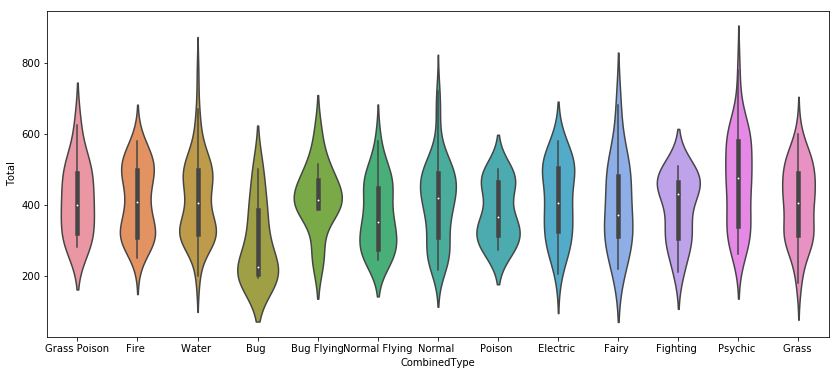

In [12]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.violinplot(data=pokemon.iloc[np.isin(pokemon['CombinedType'], combined_types), :],
               x='CombinedType', y='Total', ax=ax)

As we see above, type definitely have an effect on the value distribution and allocation of different stats. Notice that for many types, there is a bimodal pattern in their attribute distributions. This is likely due to evolution stages, and we will verify that later.

Now we look at the mean values of attributes in each commom pokemon type:

In [13]:
combined_types = pokemon.groupby('CombinedType')['#'].count().reset_index().\
    rename(columns={'#':'val'}).query('val >= 10')['CombinedType']
type_mean = pokemon.iloc[np.isin(pokemon['CombinedType'], combined_types), :]\
    .groupby('CombinedType')[["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]]\
    .mean()

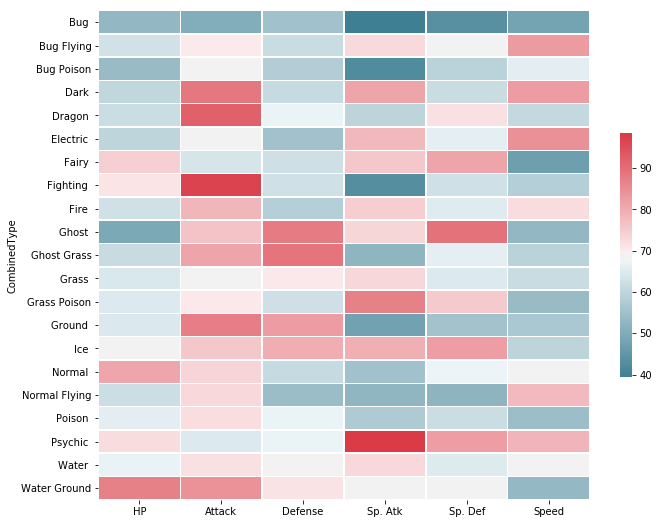

In [14]:
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(type_mean, cmap=cmap, linewidths=.5, cbar_kws={"shrink": .5})

It is also interesting to look at attribute distributions of single-typed pokemons versus double-typed pokemons.

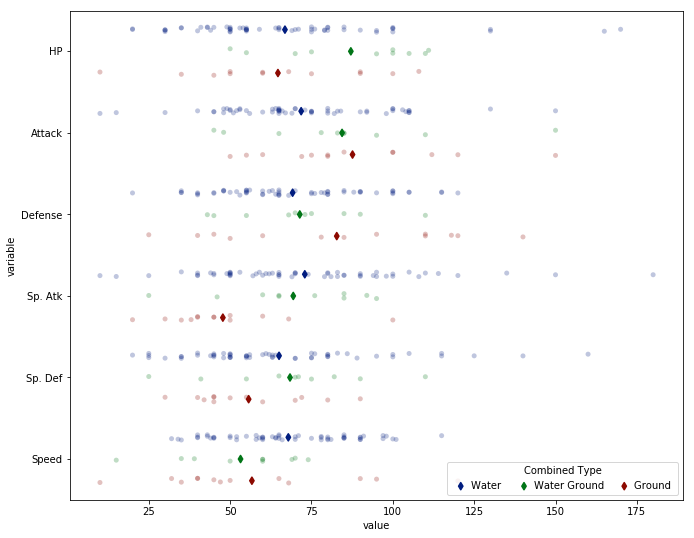

In [15]:
mm = pokemon.iloc[np.isin(pokemon['CombinedType'], ['Water ', 'Water Ground', 'Ground ']), :]\
    [['CombinedType', "HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]].melt(id_vars=['CombinedType'])
    
f, ax = plt.subplots(figsize=(11, 9))
sns.stripplot(x="value", y="variable", hue="CombinedType", hue_order=['Water ', 'Water Ground', 'Ground '],
              data=mm, dodge=True, jitter=True, palette='dark',
              alpha=.25, zorder=1)
sns.pointplot(x="value", y="variable", hue="CombinedType", hue_order=['Water ', 'Water Ground', 'Ground '],
              data=mm, dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)
# Improve the legend 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[3:], labels[3:], title="Combined Type",
          handletextpad=0, columnspacing=1,
          loc="lower right", ncol=3, frameon=True)

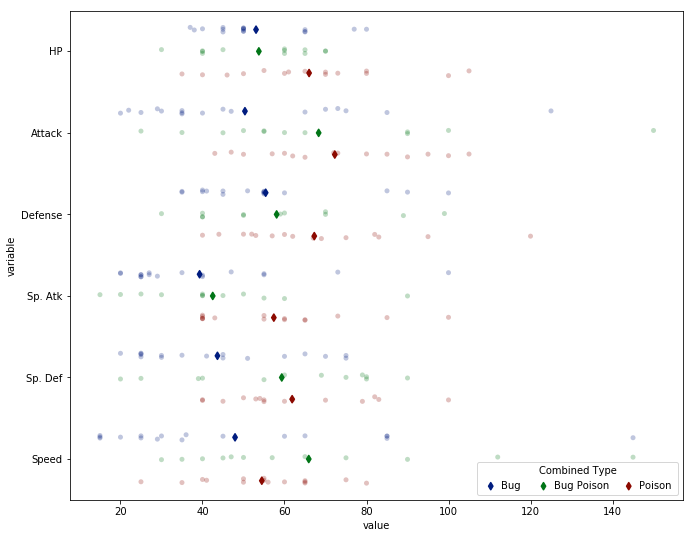

In [16]:
mm = pokemon.iloc[np.isin(pokemon['CombinedType'], ['Bug ', 'Bug Poison', 'Poison ']), :]\
    [['CombinedType', "HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]].melt(id_vars=['CombinedType'])
    
f, ax = plt.subplots(figsize=(11, 9))
sns.stripplot(x="value", y="variable", hue="CombinedType", hue_order=['Bug ', 'Bug Poison', 'Poison '],
              data=mm, dodge=True, jitter=True, palette='dark',
              alpha=.25, zorder=1)
sns.pointplot(x="value", y="variable", hue="CombinedType", hue_order=['Bug ', 'Bug Poison', 'Poison '],
              data=mm, dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)
# Improve the legend 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[3:], labels[3:], title="Combined Type",
          handletextpad=0, columnspacing=1,
          loc="lower right", ncol=3, frameon=True)

As we see here, the attributes of a combined type is not always the average of two component types.

Now we look at the joint distributions of the attributes.

/home/mithrillion/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


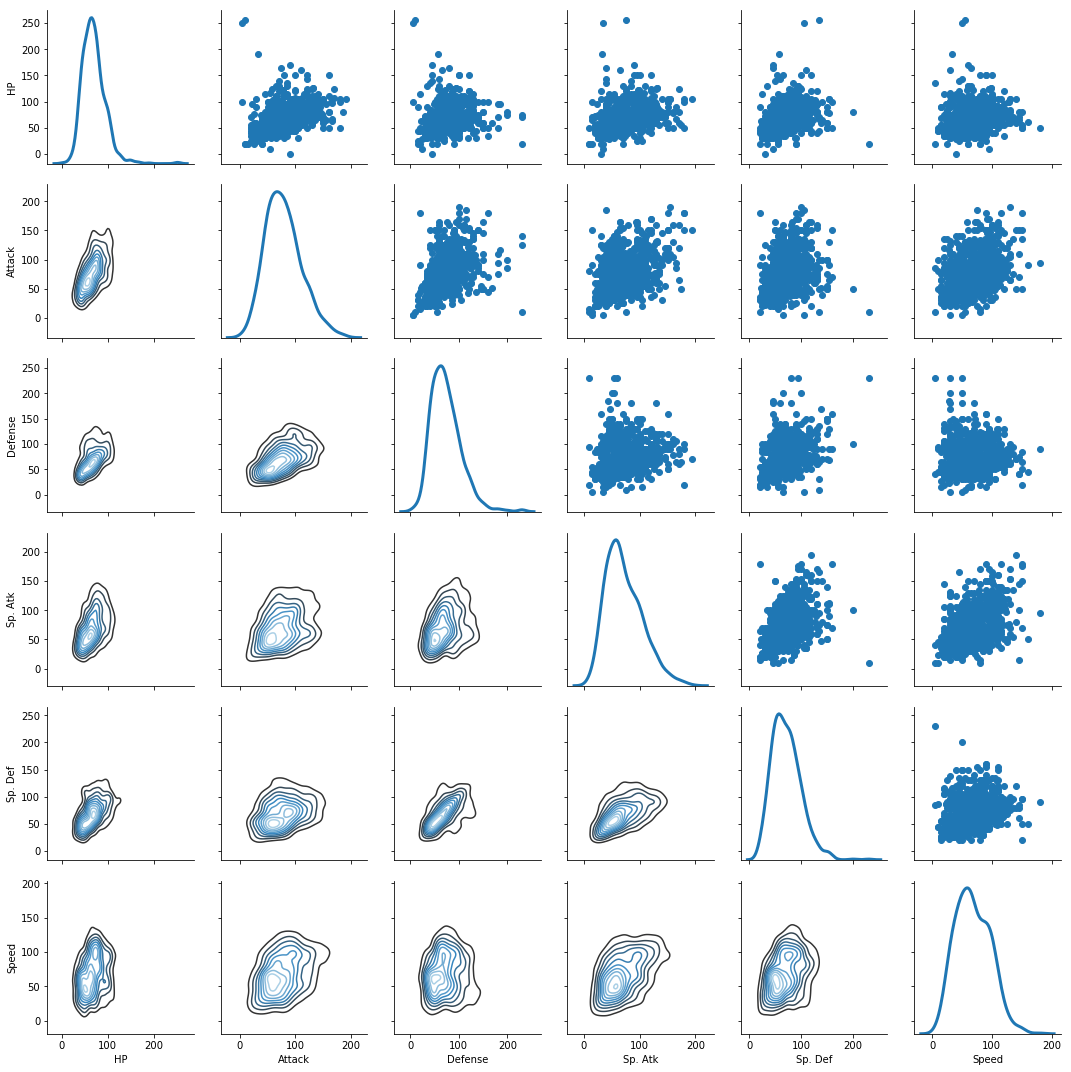

In [17]:
g = sns.PairGrid(pokemon[["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]], diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

# Modelling

Let us build a basic attribute generation model. We make the following assumptions:

1. All six attributes of a pokemon follow a joint multivariate normal distribution. The mean vector and covariance matrix are random variables to be estimated.
2. The mean vector of the attribute distribution is dependent on the type of the pokemon. For each type, the mean follows a normal distribution prior. If the pokemon has two types, the distribution of the mean is the mixture of the two component distributions.
3. "Legendary" is a multiplier on the mean of the attributes.

In [49]:
df = pokemon[['Type 1', 'Type 2', 'Legendary', 'HP', 'Attack', 'Defense',
              'Sp. Atk', 'Sp. Def', 'Speed']].copy()
df['Single'] = pd.isnull(df['Type 2'])
df.loc[pd.isnull(df['Type 2']), 'Type 2'] = df[pd.isnull(df['Type 2'])]['Type 1']
cata1 = df['Type 1'].astype('category').cat
cata1_map = {cata1.categories[i]:i for i in range(len(cata1.categories))}
df['Type 1'] = df['Type 1'].apply(lambda x: cata1_map[x])
df['Type 2'] = df['Type 2'].apply(lambda x: cata1_map[x])
df.head()

,Type 1,Type 2,Legendary,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Single
0,9,13,False,45,49,49,65,65,45,False
1,9,13,False,60,62,63,80,80,60,False
2,9,13,False,80,82,83,100,100,80,False
3,9,13,False,80,100,123,122,120,80,False
4,6,6,False,39,52,43,60,50,65,True


In [50]:
import pymc3 as pm
import theano.tensor as tt
from theano import shared
import theano as th

Let us construct the model in PyMC3. Some tricks must be used to model the prior of the covariance matrix.

In [80]:
M = 6
T = 18

with pm.Model() as model:
    type_1 = shared(df['Type 1'].astype(np.int16).values)
    type_2 = shared(df['Type 2'].astype(np.int16).values)
    leg_ph = shared(df['Legendary'].astype(np.bool).values)
    obs = shared(df.loc[:, ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']].astype(np.float32).values)

    leg = tt.reshape(leg_ph, (df.shape[0], 1))
    
    type_mu = pm.Normal("mu", mu=70., sd=10., shape=(T, M))  # prior of attr mean by type
#     r = pm.Beta("r_{mix}", 2, 2)
    w = pm.Normal("w", mu=1., sd=0.2, shape=T)
    r = w[type_1] / (w[type_1] + w[type_2])
    r = tt.reshape(r, (r.shape[0], 1))
    selected_type_mu = r * type_mu[type_1, :] + (1 - r) * type_mu[type_2, :]

#     sigma = pm.Lognormal('sigma', 30., 5.)
    
    # prior for the covariance matrix
    nu = pm.Uniform('nu', 0, 5)
    chol = pm.LKJCholeskyCov('chol', n=M, eta=nu, sd_dist=pm.Lognormal.dist(30., 5.))
    chol = pm.expand_packed_triangular(M, chol, lower=True)
    cov = pm.Deterministic("cov", tt.dot(chol, chol.T))  # dummy
    
    amp = pm.Uniform("amp", 0, 2)  # legendary multiplier, i.e. legendaries are k times stronger
    attributes = pm.MvNormal('att', mu=selected_type_mu * (leg * amp + 1), 
                             chol=chol, observed=obs)
#     attributes = pm.Normal('att', mu=selected_type_mu * (leg * amp + 1), sd=sigma, observed=obs)

In [81]:
with model:
    trace = pm.sample(2000, tune=2000, init='ADVI')

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 22,261:  74%|███████▍  | 148594/200000 [01:35<00:33, 1557.75it/s]
Convergence archived at 148600
Interrupted at 148,600 [74%]: Average Loss = 3.1732e+06
100%|█████████▉| 3992/4000 [00:53<00:00, 90.00it/s]/home/mithrillion/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 26 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 4000/4000 [00:53<00:00, 74.59it/s]


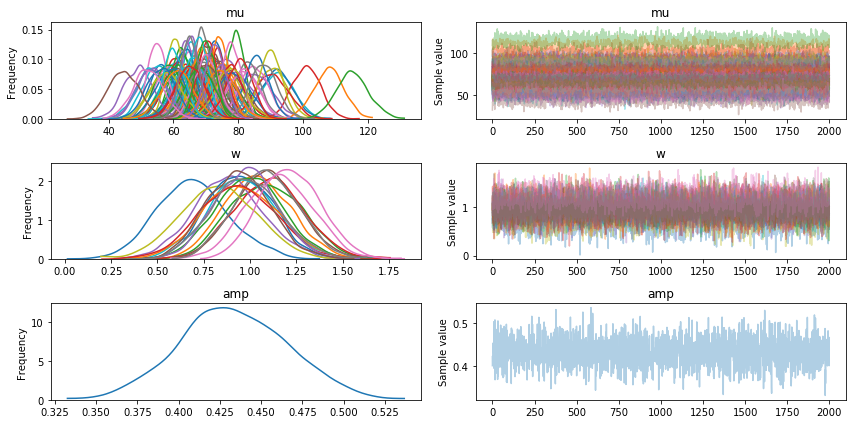

In [82]:
pm.traceplot(trace, varnames=['mu', 'w', 'amp'])
plt.show()

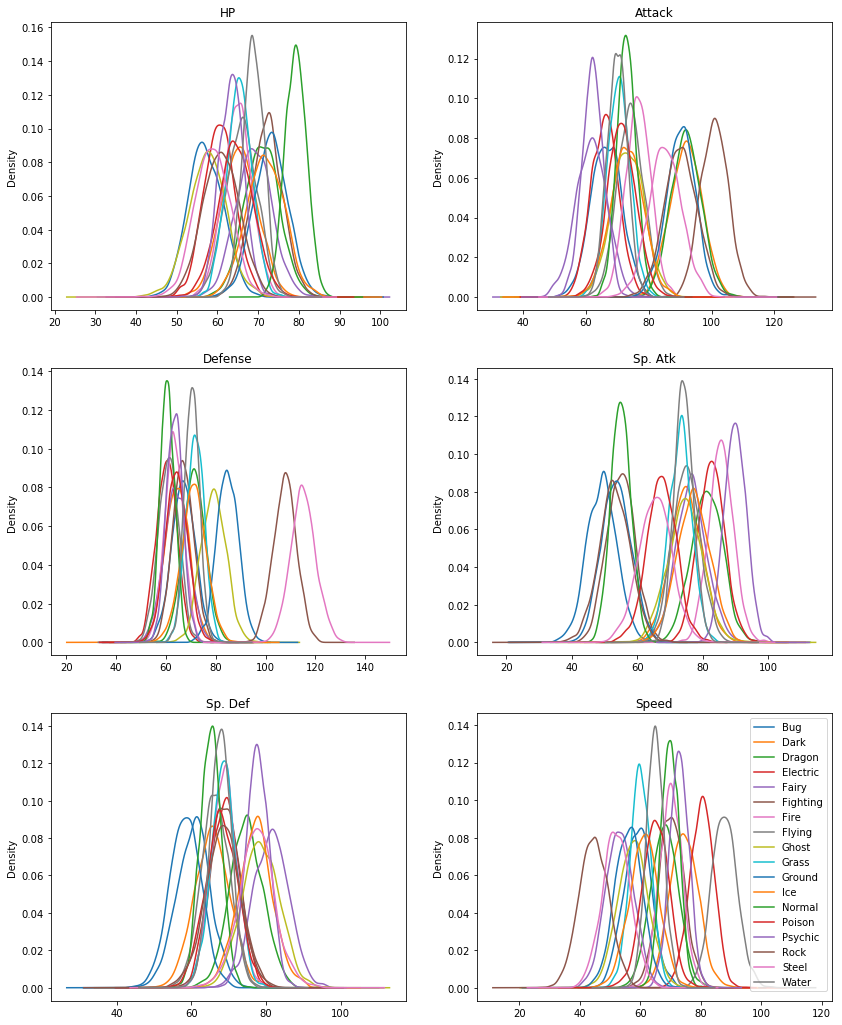

In [83]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(14, 18))
pd.DataFrame(trace['mu'][:, :, 0]).rename(columns={i:cata1.categories[i] for i in range(T)})\
    .plot.kde(title="HP", ax = ax[0, 0], legend=False)
pd.DataFrame(trace['mu'][:, :, 1]).rename(columns={i:cata1.categories[i] for i in range(T)})\
    .plot.kde(title="Attack", ax=ax[0,1], legend=False)
pd.DataFrame(trace['mu'][:, :, 2]).rename(columns={i:cata1.categories[i] for i in range(T)})\
    .plot.kde(title="Defense", ax=ax[1,0], legend=False)
pd.DataFrame(trace['mu'][:, :, 3]).rename(columns={i:cata1.categories[i] for i in range(T)})\
    .plot.kde(title="Sp. Atk", ax=ax[1,1], legend=False)
pd.DataFrame(trace['mu'][:, :, 4]).rename(columns={i:cata1.categories[i] for i in range(T)})\
    .plot.kde(title="Sp. Def", ax=ax[2,0],legend=False)
pd.DataFrame(trace['mu'][:, :, 5]).rename(columns={i:cata1.categories[i] for i in range(T)})\
    .plot.kde(title="Speed", ax=ax[2,1])
plt.show()

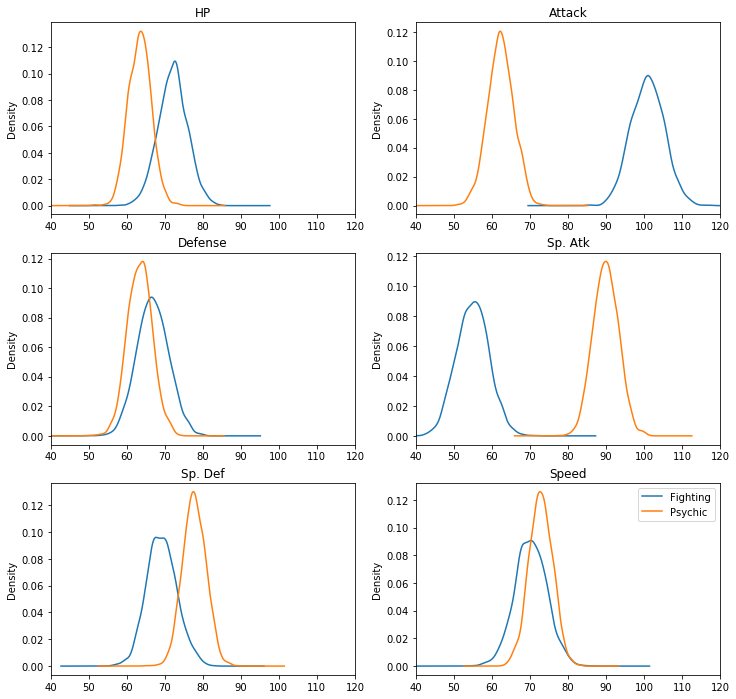

In [84]:
SELECTED_TYPE = ['Fighting', 'Psychic']
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
pd.DataFrame(trace['mu'][:, :, 0]).rename(columns={i:cata1.categories[i] for i in range(T)})[SELECTED_TYPE]\
    .plot.kde(title="HP", ax = ax[0, 0], legend=False, xlim=(40, 120))
pd.DataFrame(trace['mu'][:, :, 1]).rename(columns={i:cata1.categories[i] for i in range(T)})[SELECTED_TYPE]\
    .plot.kde(title="Attack", ax=ax[0,1], legend=False, xlim=(40, 120))
pd.DataFrame(trace['mu'][:, :, 2]).rename(columns={i:cata1.categories[i] for i in range(T)})[SELECTED_TYPE]\
    .plot.kde(title="Defense", ax=ax[1,0], legend=False, xlim=(40, 120))
pd.DataFrame(trace['mu'][:, :, 3]).rename(columns={i:cata1.categories[i] for i in range(T)})[SELECTED_TYPE]\
    .plot.kde(title="Sp. Atk", ax=ax[1,1], legend=False, xlim=(40, 120))
pd.DataFrame(trace['mu'][:, :, 4]).rename(columns={i:cata1.categories[i] for i in range(T)})[SELECTED_TYPE]\
    .plot.kde(title="Sp. Def", ax=ax[2,0],legend=False, xlim=(40, 120))
pd.DataFrame(trace['mu'][:, :, 5]).rename(columns={i:cata1.categories[i] for i in range(T)})[SELECTED_TYPE]\
    .plot.kde(title="Speed", ax=ax[2,1], xlim=(40, 120))
plt.show()

PPC check:

In [85]:
from theano import printing, function

In [86]:
with model:
    samp = pm.sample_ppc(trace, 1000)

100%|██████████| 1000/1000 [00:00<00:00, 3242.93it/s]


In [87]:
labels = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']

Posterior value:

In [88]:
pd.DataFrame(samp['att'].reshape(-1, 6), columns=labels).agg([np.mean, np.std, 
                                                              lambda x: x.quantile(0.05),
                                                              lambda x: x.quantile(0.95)])

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
mean,68.974403,78.615622,73.644142,73.819290,72.105009,68.877538
std,25.605931,31.852225,30.785300,32.975241,27.678306,28.373661
<lambda>,28.629572,26.628166,23.069715,21.354256,28.584705,24.239669
<lambda>,111.452610,132.691238,125.379281,130.089381,119.864471,117.626143


Data value:

In [89]:
df[labels].agg([np.mean, np.std, lambda x: x.quantile(0.05), lambda x: x.quantile(0.95)])

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
mean,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500
std,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474
<lambda>,35.950000,30.000000,35.000000,30.000000,32.950000,25.000000
<lambda>,110.000000,136.200000,130.000000,131.050000,120.000000,115.000000


As we see here, our sample estimate is somewhat close to the true data values, but there are some underestimates and overestimates. We suspect this is due to the fact that being legendary affects different attributes differently, and when two types mix, they do not affect each attribute equally.

Let us compare the distribution of different attributes from the posterior sample and from the data:

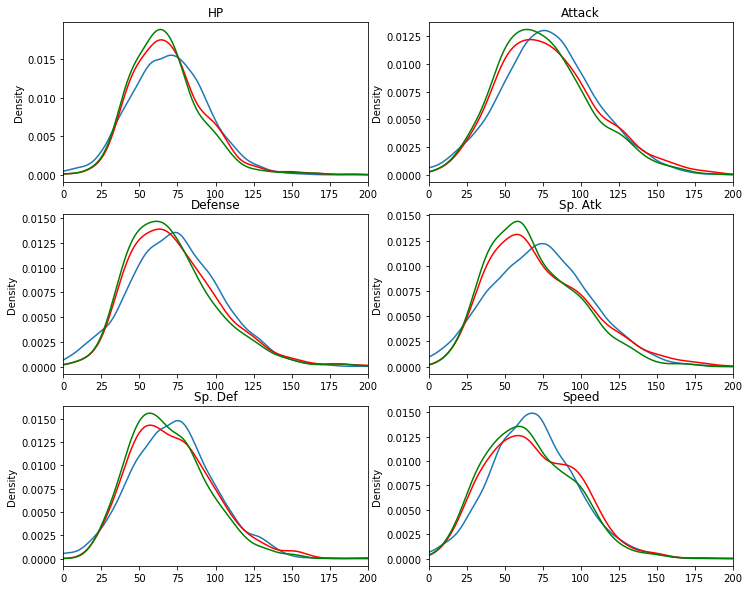

In [90]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
tdf = pd.DataFrame(samp['att'].reshape(-1, 6))
for i in range(3):
    for j in range(2):
        tdf.iloc[:, 2 * i + j].sample(10000).plot.kde(xlim=(0, 200), 
                                        title=labels[2 * i + j], 
                                        ax=ax[i, j])
tdf = pd.DataFrame(df[labels])
for i in range(3):
    for j in range(2):
        tdf.iloc[:, 2 * i + j].plot.kde(xlim=(0, 200), 
                                        title=labels[2 * i + j],
                                        ax=ax[i, j], color='red')
tdf = pd.DataFrame(df.query('Legendary == False')[labels])
for i in range(3):
    for j in range(2):
        tdf.iloc[:, 2 * i + j].plot.kde(xlim=(0, 200), 
                                        title=labels[2 * i + j],
                                        ax=ax[i, j], color='green')
plt.show()

One interesting observation from the posterior is that not all types affect the attributes equally.

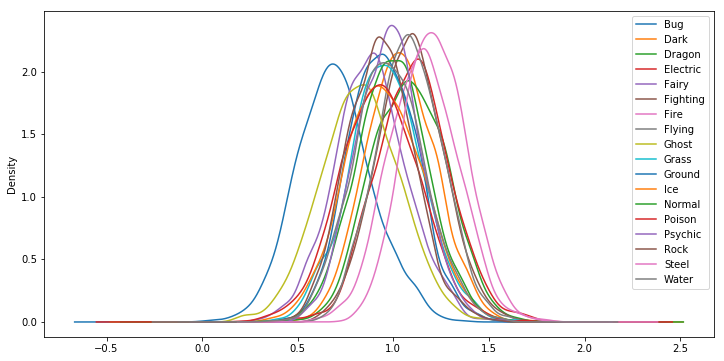

In [91]:
f, ax = plt.subplots(figsize=(12, 6))
pd.DataFrame(trace['w'], columns=cata1.categories).plot.kde(ax=ax)

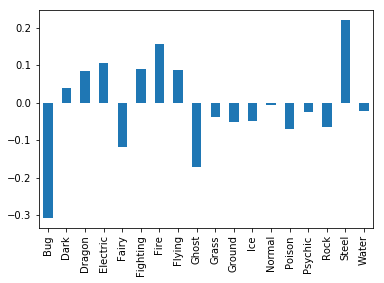

In [92]:
(pd.DataFrame(trace['w'], columns=cata1.categories).mean() - 1).plot.bar()

Although the effect is subtle and the result is not likely to be very significant, we do find that Steel type is more likely to dominate the stat allocation in mixed-type pokemons and Bug type tends to have a smaller influence in mixed-types.

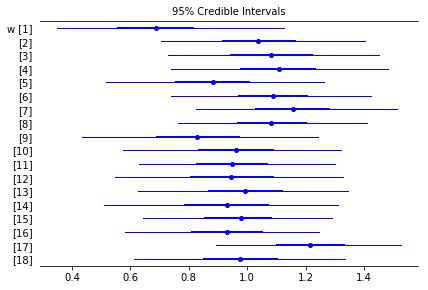

In [168]:
pm.plots.forestplot(trace, varnames=['w'])
plt.show()

As we see above, pretty much all of the type weights' 95% credible intervals overlap, so we really cannot conclude for certain whether some types affect attributes more than others.

We may also investigate the covariance matrix and derive our estimate of attribute correlation from it. Let us contrast this with the correlation matrix from the data:

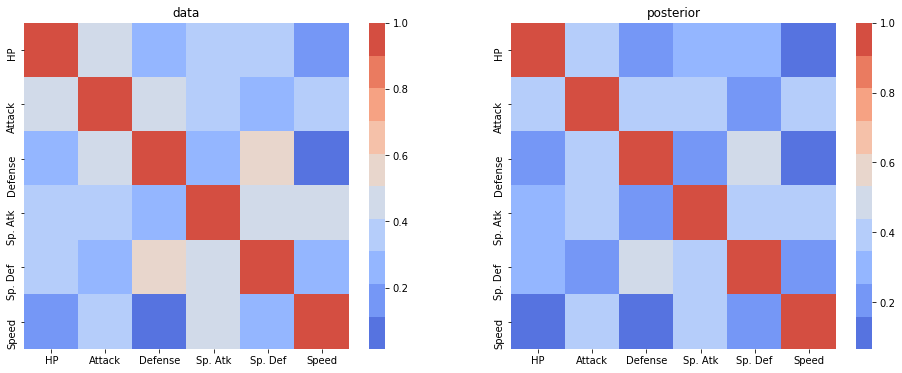

In [93]:
cov_mean = trace['cov'].mean(axis=0)
cov_diag = np.sqrt(np.diag(cov_mean))
corr = pd.DataFrame(cov_mean / cov_diag.reshape(-1, 1) / cov_diag.reshape(1, -1), index=labels, columns=labels)

f, ax = plt.subplots(figsize=(16, 6), ncols=2)
ax[0].set_title("data")
sns.heatmap(df[labels].corr(), ax=ax[0], cmap=sns.color_palette("coolwarm", 10))
ax[1].set_title('posterior')
sns.heatmap(corr, ax=ax[1], cmap=sns.color_palette("coolwarm", 10))
plt.show()

Since we have modelled the effect of types and legendary status on the attributes, the correlation being explained by the multivariate normal distribution is smaller than that in the data overall (e.g. in many types, Sp. Atk and Sp.Def are either high or low at the same time). However, there seems to be a correlation between Defense and Sp.Def that is not sufficiently explained by our type model.

# Investigating the Relationship between Attributes Given Total

So far, we have modelled the relationship between the attributes of a pokemon and its types. What if we include the total attribute points of a pokemon as an input variable?

In [94]:
pos = pd.DataFrame(samp['att'].reshape(-1, M), columns=labels)
pos['Total'] = pos.sum(axis=1)
pos.describe()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Total
count,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000
mean,68.974403,78.615622,73.644142,73.819290,72.105009,68.877538,436.036005
std,25.605931,31.852225,30.785300,32.975241,27.678306,28.373661,120.747405
min,-31.722426,-33.551296,-36.212500,-38.006214,-37.060031,-40.516646,12.080345
25%,51.657916,57.518798,53.146296,51.043253,53.217179,49.886455,354.405859
50%,68.645802,78.144771,72.686168,72.881999,71.753949,67.813570,432.159759
75%,85.863631,99.095864,93.614305,95.221769,89.551895,86.667565,509.773209
max,196.364808,225.712034,251.480591,219.566519,209.852957,218.067676,1000.869678


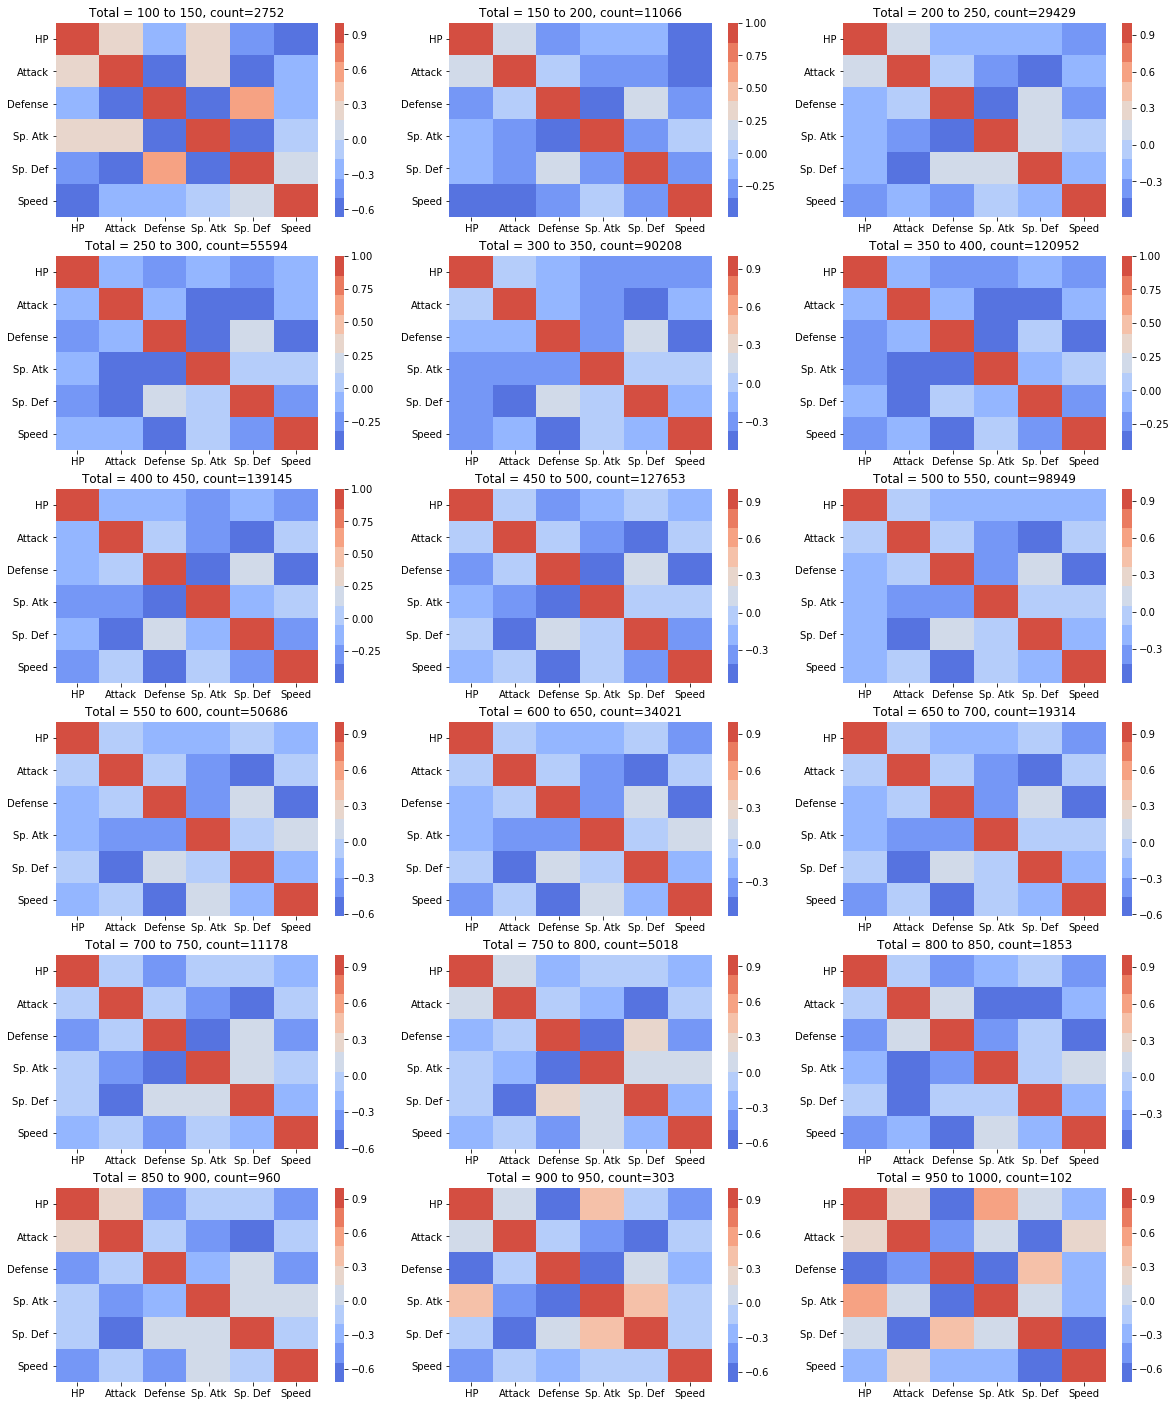

In [95]:
nr = 6
nc = 3
f, ax = plt.subplots(figsize=(20, 25), nrows=nr, ncols=nc)
START = 100
RANGE = 50
for i in range(nr * nc):
    slice_dat = pos.loc[(pos['Total'] >= START + RANGE * i) & (pos['Total'] < START + RANGE * (1 + i)), :]\
        .iloc[:-1, :-1]
    ax[i//nc, i%nc].set_title("Total = {0} to {1}, count={2}"\
                            .format(START + RANGE * i, START + RANGE * (1 + i), slice_dat.shape[0]))
    slice_cov = slice_dat.cov()
    slice_diag = np.sqrt(np.diag(slice_cov))
    corr = pd.DataFrame(slice_cov.values / slice_diag.reshape(-1, 1) / slice_diag.reshape(1, -1),
                        columns=labels, index=labels)
    sns.heatmap(corr, cmap=sns.color_palette("coolwarm", 10), ax=ax[i//nc, i%nc])
plt.show()

Here we can look at how the relationships between attributes change over the range of total attribute points. There are more positive correlation between certain attribute pairs at very low and very high total attr ranges (altough likely be chance). Opposite attack and defense (e.g. Attack vs Sp. Def) seems to be consistently negatively correlated given total attrs. Speed and Defense are more consistently negatively correlated.

# Fun Time - Find the weirdest Pokemon!

We define "weirdness" as having low likeliness as predicted by our model. To find the most unlikely Pokemon, we need to calculate the likeliness for each row:

In [108]:
with model:
    logp = attributes.logp_elemwise(mu=trace['mu'].mean(axis=0), 
                   w=trace['w'].mean(axis=0),
                   nu_interval__=trace['nu_interval__'].mean(axis=0),
                   chol_cholesky_cov_packed__=trace['chol_cholesky_cov_packed__'].mean(axis=0),
                   amp_interval__=trace['amp_interval__'].mean(axis=0))

Now we just have to rank the Pokemons by their log-likeliness:

In [113]:
sort_ind = np.argsort(logp)

And here is our 20 weirdest Pokemon:

In [118]:
pokemon.iloc[sort_ind[:20], :]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
261,242,Blissey,Normal,NaN,540,255,10,10,75,135,55,2,False
121,113,Chansey,Normal,NaN,450,250,5,5,35,105,50,1,False
230,213,Shuckle,Bug,Rock,505,20,10,230,10,230,5,2,False
217,202,Wobbuffet,Psychic,NaN,405,190,33,58,33,58,33,2,False
429,386,DeoxysAttack Forme,Psychic,NaN,600,50,180,20,180,20,150,3,True
789,713,Avalugg,Ice,NaN,514,95,117,184,44,46,28,6,False
19,15,BeedrillMega Beedrill,Bug,Poison,495,65,150,40,15,80,145,1,False
98,91,Cloyster,Water,Ice,525,50,95,180,85,45,70,1,False
87,80,SlowbroMega Slowbro,Water,Psychic,590,95,75,180,130,80,30,1,False
655,594,Alomomola,Water,NaN,470,165,75,80,40,45,65,5,False


We have a winner!
![Blissey](./250px-242Blissey.png)

And here are the most "ordinary" Pokemons:

In [120]:
pokemon.iloc[sort_ind[::-1][:20], :]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
160,148,Dragonair,Dragon,NaN,420,61,84,65,70,70,70,1,False
262,243,Raikou,Electric,NaN,580,90,85,75,115,100,115,2,True
38,33,Nidorino,Poison,NaN,365,61,72,57,55,55,65,1,False
695,634,Zweilous,Dark,Dragon,420,72,85,70,65,70,58,5,False
391,358,Chimecho,Psychic,NaN,425,65,50,70,95,80,65,3,False
285,262,Mightyena,Dark,NaN,420,70,90,70,60,60,70,3,False
5,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,1,False
170,156,Quilava,Fire,NaN,405,58,64,58,80,65,80,2,False
703,641,TornadusTherian Forme,Flying,NaN,580,79,100,80,110,90,121,5,True
21,17,Pidgeotto,Normal,Flying,349,63,60,55,50,50,71,1,False


![Dragonair](./File-148Dragonair.png)

Putting two parallel plots togther and we can easily see why they are in their categories respectively:

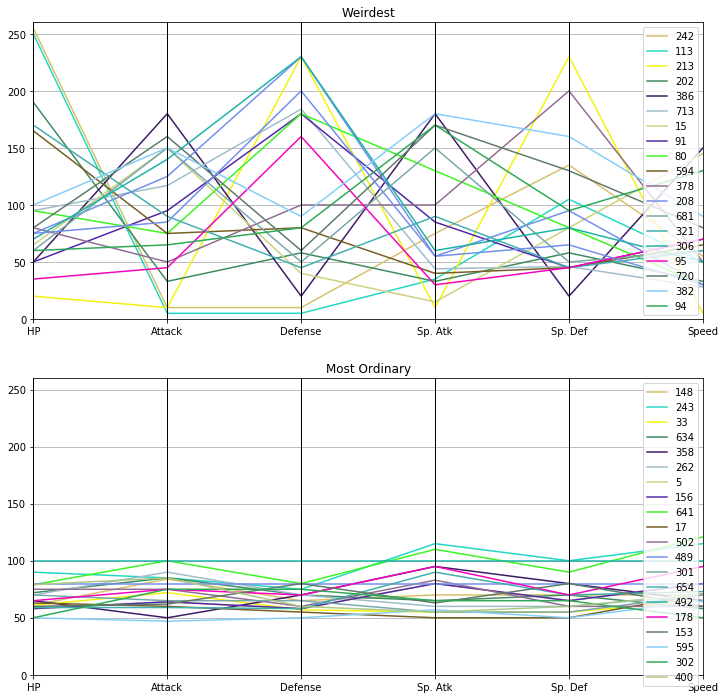

In [158]:
f, ax = plt.subplots(figsize=(12, 12), nrows=2)
melted = pokemon.iloc[sort_ind[:20], [0,5,6,7,8,9,10]].melt(id_vars="#")
pd.plotting.parallel_coordinates(pokemon.iloc[sort_ind[:20], [0,5,6,7,8,9,10]], class_column='#', ax=ax[0])
ax[0].axes.set_ylim(0, 260)
ax[0].set_title("Weirdest")
melted = pokemon.iloc[sort_ind[::-1][:20], [0,5,6,7,8,9,10]].melt(id_vars="#")
pd.plotting.parallel_coordinates(pokemon.iloc[sort_ind[::-1][:20], [0,5,6,7,8,9,10]], class_column='#', ax=ax[1])
ax[1].axes.set_ylim(0, 260)
ax[1].set_title("Most Ordinary")
plt.show()

# Same Model in Edward (Except no Covariance)

In [4]:
df.head()

,Type 1,Type 2,Legendary,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Single
0,9,13,False,45,49,49,65,65,45,False
1,9,13,False,60,62,63,80,80,60,False
2,9,13,False,80,82,83,100,100,80,False
3,9,13,False,80,100,123,122,120,80,False
4,6,6,False,39,52,43,60,50,65,True


In [5]:
import tensorflow as tf
import edward as ed
from edward import models

In [34]:
# define model
type_ph = tf.placeholder(tf.int32, shape=(None, 2))
legendary_ph = tf.placeholder(tf.float32, shape=(None, 1))
single_ph = tf.placeholder(tf.float32, shape=(None, 1))

M = 6
T = 18
type_mu = models.Normal(tf.ones([T, M]) * 70., tf.ones([T, M]) * 20.)
r = models.Beta(2., 2.)
selected_type_mu = single_ph * tf.gather(type_mu, type_ph[:, 0]) \
    + (1. - single_ph) * (r * tf.gather(type_mu, type_ph[:, 0]) + (1. - r) * tf.gather(type_mu, type_ph[:, 1]))
    
logsigma = models.Normal(tf.ones([M]) * tf.sqrt(30.), 5.)

amp = models.Uniform(1., 3.)
# multiplied = tf.cond(legendary_ph, lambda: selected_type_mu * amp, lambda: selected_type_mu)
multiplied = legendary_ph * selected_type_mu * amp + (1. - legendary_ph) * selected_type_mu
attr = models.Normal(multiplied, tf.exp(logsigma))

# inference
qmu = models.NormalWithSoftplusScale(tf.Variable(tf.ones([T, M]) * 70.),
                    tf.Variable(tf.ones([T, M])))
qr = models.Normal(tf.Variable(tf.ones([]) * 0.5), tf.sigmoid(tf.Variable(tf.ones([]))))
qlogsigma = models.NormalWithSoftplusScale(tf.Variable(tf.ones([M]) * tf.sqrt(30.)),
                          tf.Variable(tf.ones(M)))
qamp = models.NormalWithSoftplusScale(tf.Variable(tf.ones([]) * 2.), tf.Variable(tf.ones([])))

latent_vars = {
    type_mu: qmu,
    r: qr,
    logsigma: qlogsigma,
    amp: qamp}
data = {
    attr: df.iloc[:, 3:9].values,
    type_ph: df.iloc[:, :2].values,
    legendary_ph: df['Legendary'].values.reshape(-1, 1),
    single_ph: df['Single'].values.reshape(-1, 1)}

In [35]:
inference = ed.KLqp(latent_vars, data)
inference.initialize(n_print=200, n_iter=20000)
tf.global_variables_initializer().run()

for _ in range(inference.n_iter):
  # Update and print progress of algorithm.
  info_dict = inference.update()
  inference.print_progress(info_dict)

20000/20000 [100%] ██████████████████████████████ Elapsed: 37s | Loss: 22649.377


In [36]:
attr_post = ed.copy(attr, {
        type_mu: qmu,
        r: qr,
        logsigma: qlogsigma,
        amp: qamp
    })

In [37]:
ppc = attr_post.eval(feed_dict={
        type_ph: df.iloc[:, :2].values,
        legendary_ph: df['Legendary'].values.reshape(-1, 1),
        single_ph: df['Single'].values.reshape(-1, 1)
    })
ppc

array([[  74.96718597,  109.35826874,   39.96952438,   78.07138062,
          26.23586273,   87.94366455],
       [  16.69675827,  113.60899353,   56.53892517,   72.48873901,
          33.20632172,   65.78070831],
       [  80.61341858,  111.76400757,   56.8536377 ,   77.31996918,
          54.41426086,    6.81426239],
       ..., 
       [ 128.6711731 ,  112.41104126,   95.27816772,  119.00189972,
          85.32633209,   72.8128891 ],
       [  92.95095825,  130.96331787,  114.48686218,   62.32194138,
         114.72101593,  148.47799683],
       [  86.84735107,   78.25289917,  170.51583862,  127.98939514,
          75.78542328,   66.81939697]], dtype=float32)

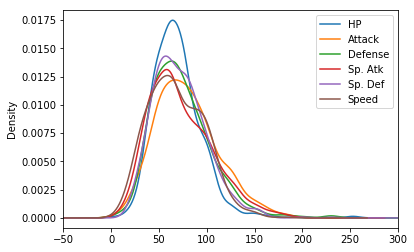

In [38]:
df.iloc[:, 3:9].plot.kde(xlim=(-50, 300))

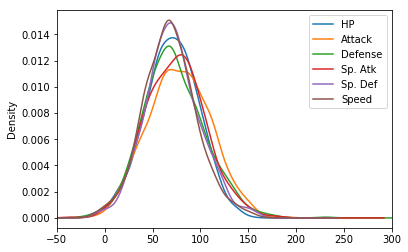

In [39]:
labels = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
pd.DataFrame(ppc, columns=labels).plot.kde(xlim=(-50, 300))

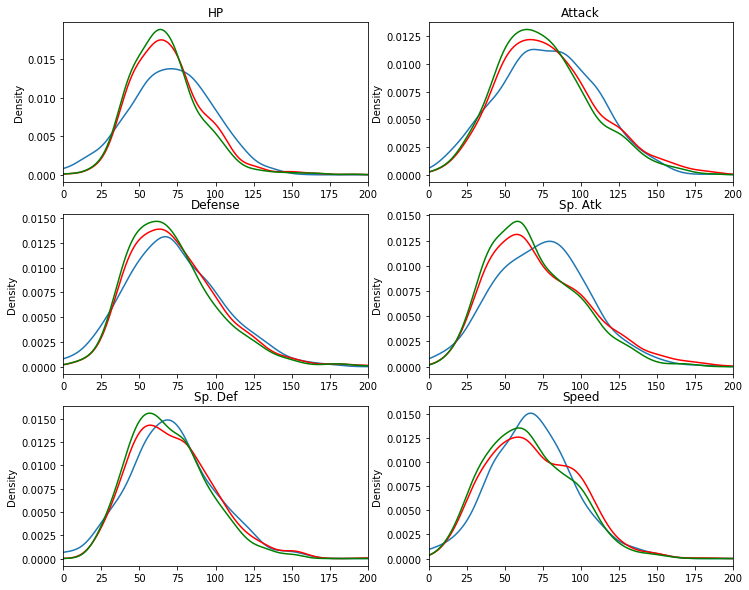

In [47]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
tdf = pd.DataFrame(ppc, columns=labels)
for i in range(3):
    for j in range(2):
        tdf.iloc[:, 2 * i + j].plot.kde(xlim=(0, 200), 
                                        title=labels[2 * i + j], 
                                        ax=ax[i, j])
tdf = pd.DataFrame(df[labels])
for i in range(3):
    for j in range(2):
        tdf.iloc[:, 2 * i + j].plot.kde(xlim=(0, 200), 
                                        title=labels[2 * i + j],
                                        ax=ax[i, j], color='red')
tdf = pd.DataFrame(df.query('Legendary == False')[labels])
for i in range(3):
    for j in range(2):
        tdf.iloc[:, 2 * i + j].plot.kde(xlim=(0, 200), 
                                        title=labels[2 * i + j],
                                        ax=ax[i, j], color='green')
plt.show()

In [41]:
df.iloc[:, 3:9].mean()

HP         69.25875
Attack     79.00125
Defense    73.84250
Sp. Atk    72.82000
Sp. Def    71.90250
Speed      68.27750
dtype: float64

In [42]:
pd.Series(qmu.mean().eval().mean(axis=0), index=labels)

HP         66.133247
Attack     78.085739
Defense    73.632477
Sp. Atk    70.394440
Sp. Def    70.443016
Speed      64.365875
dtype: float32

In [43]:
tr = qmu.sample(1000).eval()

In [44]:
tr.shape

(1000, 18, 6)

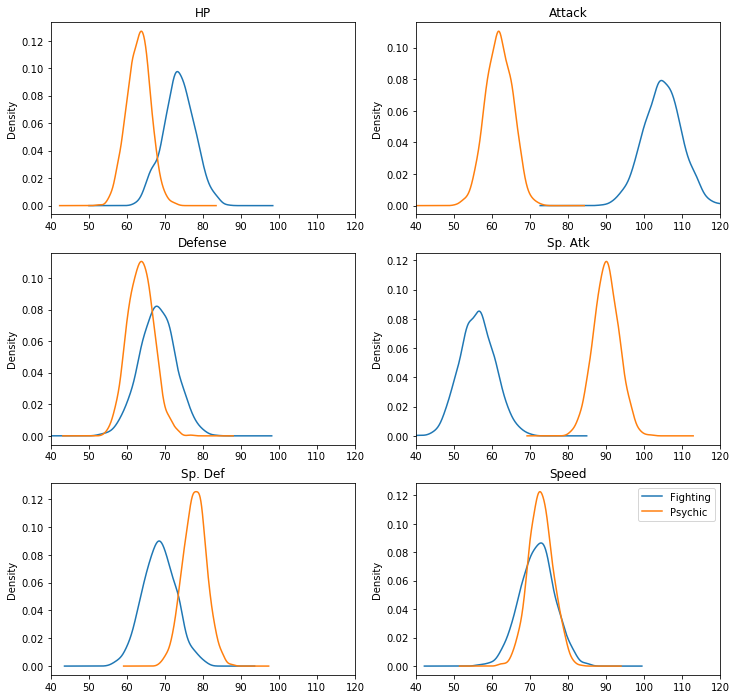

In [45]:
SELECTED_TYPE = ['Fighting', 'Psychic']
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
pd.DataFrame(tr[:, :, 0]).rename(columns={i:cata1.categories[i] for i in range(T)})[SELECTED_TYPE]\
    .plot.kde(title="HP", ax = ax[0, 0], legend=False, xlim=(40, 120))
pd.DataFrame(tr[:, :, 1]).rename(columns={i:cata1.categories[i] for i in range(T)})[SELECTED_TYPE]\
    .plot.kde(title="Attack", ax=ax[0,1], legend=False, xlim=(40, 120))
pd.DataFrame(tr[:, :, 2]).rename(columns={i:cata1.categories[i] for i in range(T)})[SELECTED_TYPE]\
    .plot.kde(title="Defense", ax=ax[1,0], legend=False, xlim=(40, 120))
pd.DataFrame(tr[:, :, 3]).rename(columns={i:cata1.categories[i] for i in range(T)})[SELECTED_TYPE]\
    .plot.kde(title="Sp. Atk", ax=ax[1,1], legend=False, xlim=(40, 120))
pd.DataFrame(tr[:, :, 4]).rename(columns={i:cata1.categories[i] for i in range(T)})[SELECTED_TYPE]\
    .plot.kde(title="Sp. Def", ax=ax[2,0],legend=False, xlim=(40, 120))
pd.DataFrame(tr[:, :, 5]).rename(columns={i:cata1.categories[i] for i in range(T)})[SELECTED_TYPE]\
    .plot.kde(title="Speed", ax=ax[2,1], xlim=(40, 120))
plt.show()